In [1]:
import mphot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

In [2]:
dichroic_path = "../resources/systems/optics/Coating design_f8 beam(SPECULOOS plate dichroic)_asahi.csv"  # index in microns, efficiency as fraction
df_dichroic = pd.read_csv(dichroic_path, index_col=0)

Wavelength at min transmission: 942.000 nm
Wavelength at max transmission: 962.000 nm
Transition wavelength: 952.000 nm
Width of transition: 20.000 nm
Calculated slope: 2.12 %


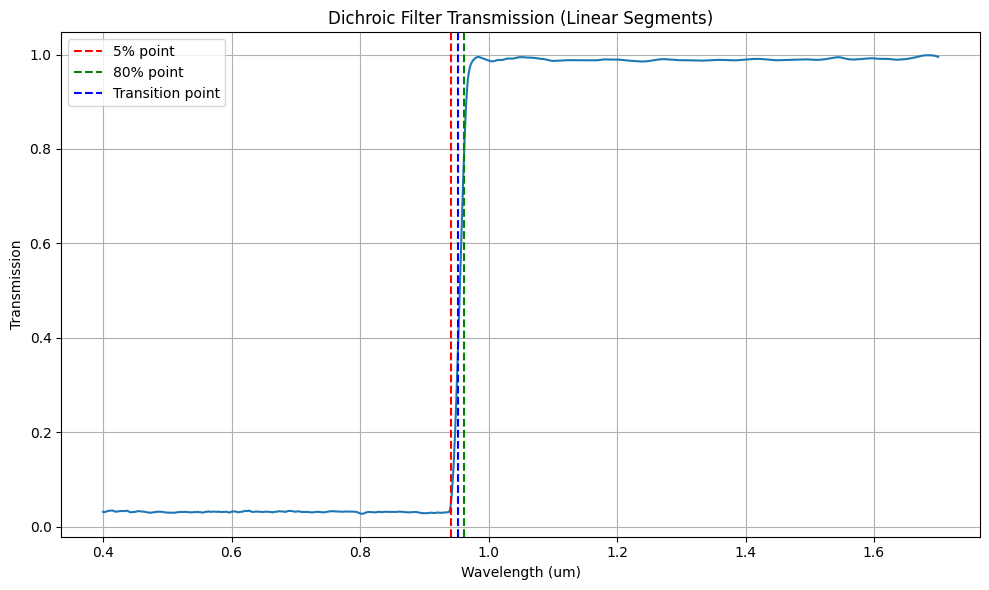

In [ ]:
# Define parameters
blue_transmission = 0.05  # Transmission in the blue region (near 0%)
red_transmission = 0.8  # Transmission in the red region (100%)

# Calculate the dichroic filter transmission
wavelength, transmission = df_dichroic.index[100:-100], df_dichroic.R.values[100:-100]

# Calculate transition points from the curve
# Find the wavelengths at min and max points
idx_min = ((transmission - blue_transmission) > 0).argmax()
idx_max = np.abs(transmission - red_transmission).argmin()

w_min_percent = wavelength[idx_min]
w_max_percent = wavelength[idx_max]
w_width = w_max_percent - w_min_percent
transition_wavelength = (w_min_percent + w_max_percent) / 2

# Calculate the actual slope
slope_calc = (w_max_percent - w_min_percent) / w_min_percent * 100

# Print the results
print(f"Wavelength at min transmission: {w_min_percent*1000:.3f} nm")
print(f"Wavelength at max transmission: {w_max_percent*1000:.3f} nm")
print(f"Transition wavelength: {transition_wavelength*1000:.3f} nm")
print(f"Width of transition: {w_width*1000:.3f} nm")
# print(f"Width of transition (expected): {expected_w_width*1000:.3f} nm")
print(f"Calculated slope: {slope_calc:.2f} %")

plt.figure(figsize=(10, 6))
plt.plot(wavelength, transmission)
plt.axvline(
    x=w_min_percent,
    color="r",
    linestyle="--",
    label=f"{blue_transmission*100:.0f}% point",
)
plt.axvline(
    x=w_max_percent,
    color="g",
    linestyle="--",
    label=f"{red_transmission*100:.0f}% point",
)
plt.axvline(
    x=transition_wavelength, color="b", linestyle="--", label="Transition point"
)
plt.title("Dichroic Filter Transmission (Linear Segments)")
plt.xlabel("Wavelength (um)")
plt.ylabel("Transmission")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

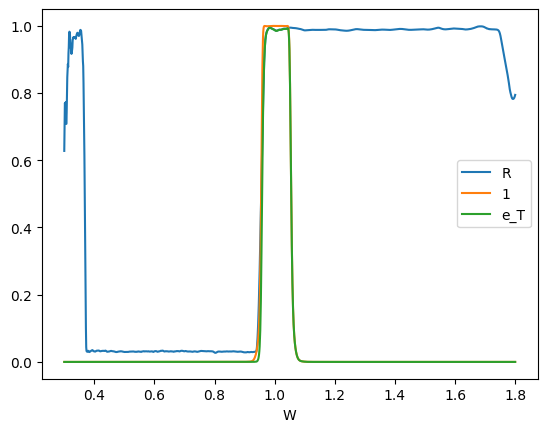

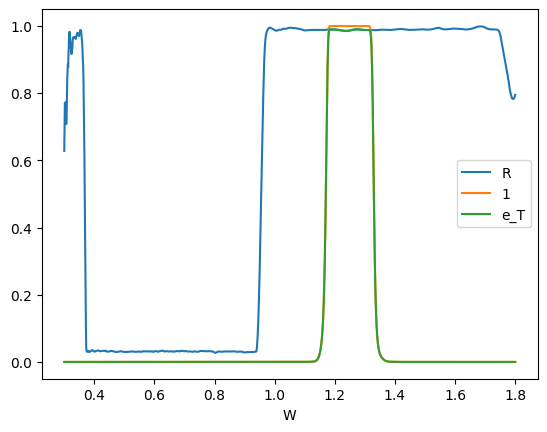

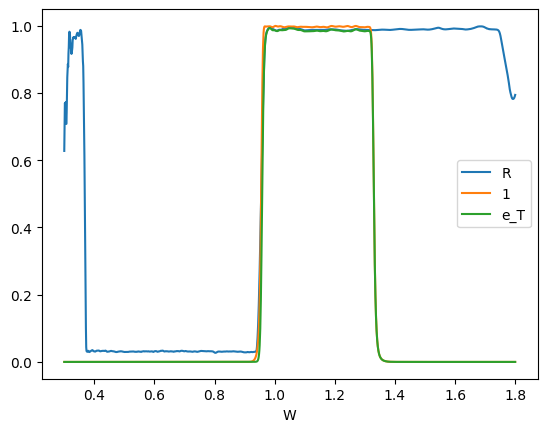

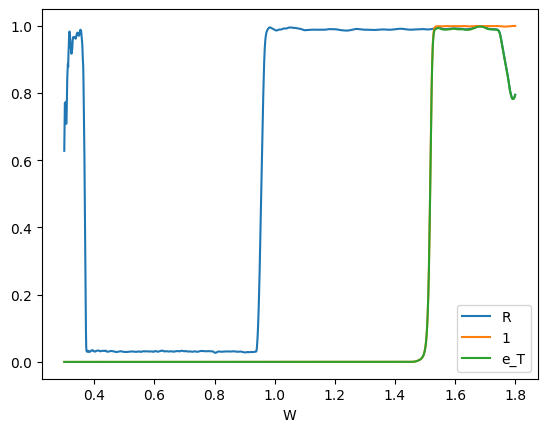

In [24]:
for filter_path in glob("../resources/filters/*_asahi.csv"):

    if "dichroic" in filter_path:
        continue

    df_filter = pd.read_csv(filter_path, index_col=0, header=None)

    IR_effective_transmission = mphot.interpolate_dfs(
        df_dichroic.index, df_dichroic["R"], df_filter
    )
    IR_effective_transmission["e_T"] = IR_effective_transmission["R"] * df_filter[1]

    IR_effective_transmission["e_T"].to_csv(
        filter_path.replace("_asahi.csv", "+dichroic_asahi.csv"), header=None
    )

    IR_effective_transmission.plot()  # IR_effective_transmission

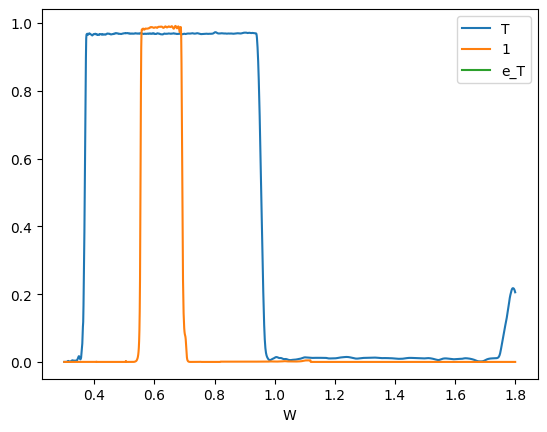

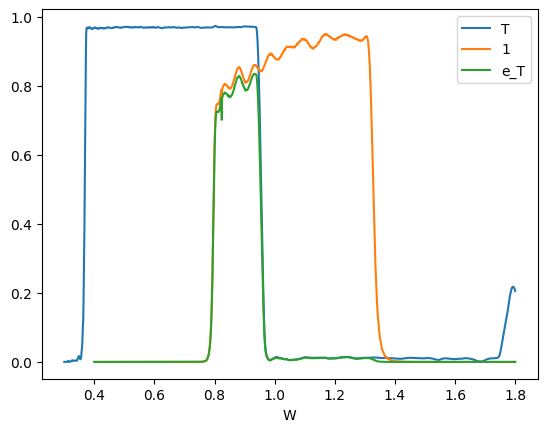

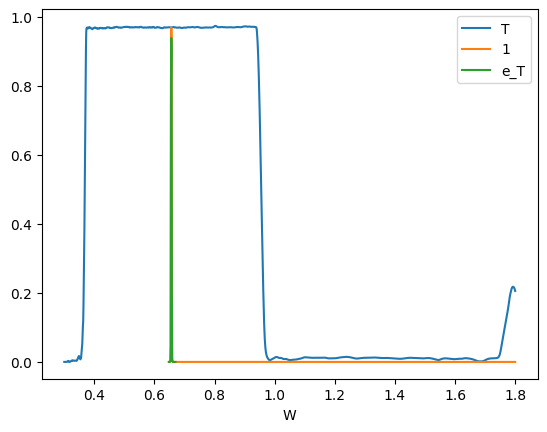

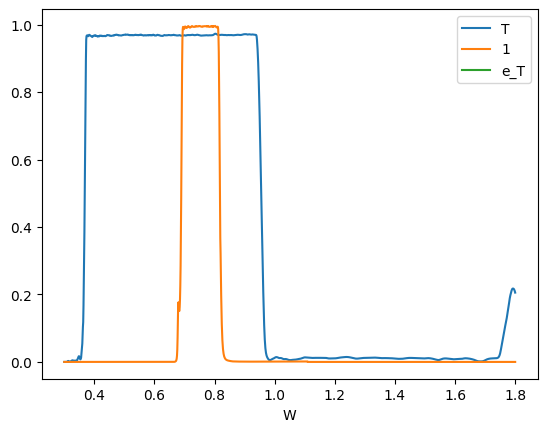

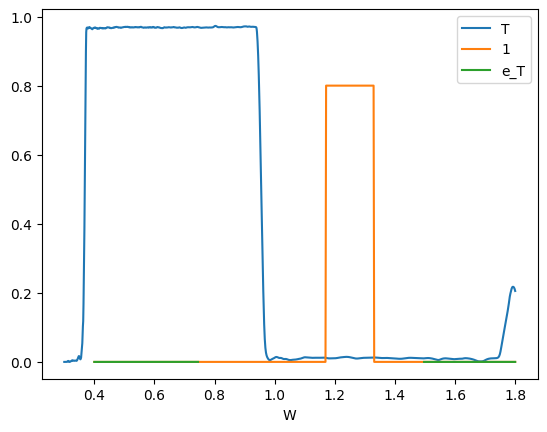

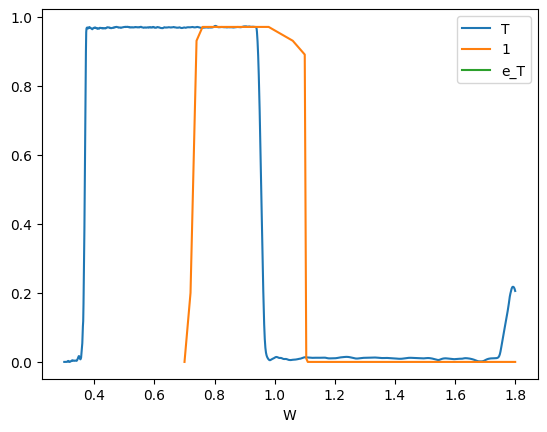

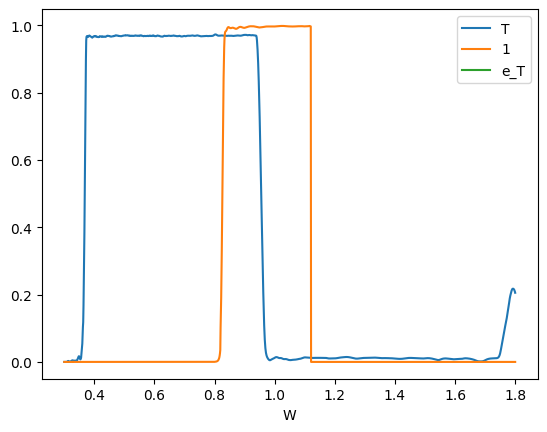

In [27]:
for filter_path in glob("../resources/filters/*.csv"):

    if "asahi" in filter_path:
        continue

    df_filter = pd.read_csv(filter_path, index_col=0, header=None)

    IR_effective_transmission = mphot.interpolate_dfs(
        df_dichroic.index, df_dichroic["T"], df_filter
    )
    IR_effective_transmission["e_T"] = IR_effective_transmission["T"] * df_filter[1]

    IR_effective_transmission["e_T"].to_csv(
        filter_path.replace(".csv", "+dichroic_transmission.csv"), header=None
    )

    IR_effective_transmission.plot()  # IR_effective_transmission


=== Filter: J+dichroic ===
Crossing 1:
  Wavelength at 5%: 1154.620 nm
  Wavelength at 80%: 1174.431 nm
  Transition wavelength: 1164.525 nm
  Calculated slope: 1.72 %
  Crossing OD4: 1098.484 nm
  Wavelength difference: -66.041 nm
Crossing 2:
  Wavelength at 5%: 1343.939 nm
  Wavelength at 80%: 1325.475 nm
  Transition wavelength: 1334.707 nm
  Calculated slope: -1.37 %
  Crossing OD4: 1411.675 nm
  Wavelength difference: 76.968 nm

Main transition regions:
5% transition: 1154.620 - 1343.939 nm (width: 189.320 nm)
80% transition: 1174.431 - 1325.475 nm (width: 151.044 nm)
5% center: 1249.279 nm
80% center: 1249.953 nm
Mean transmission in 5% region: 0.8452
Mean transmission in 80% region: 0.9818


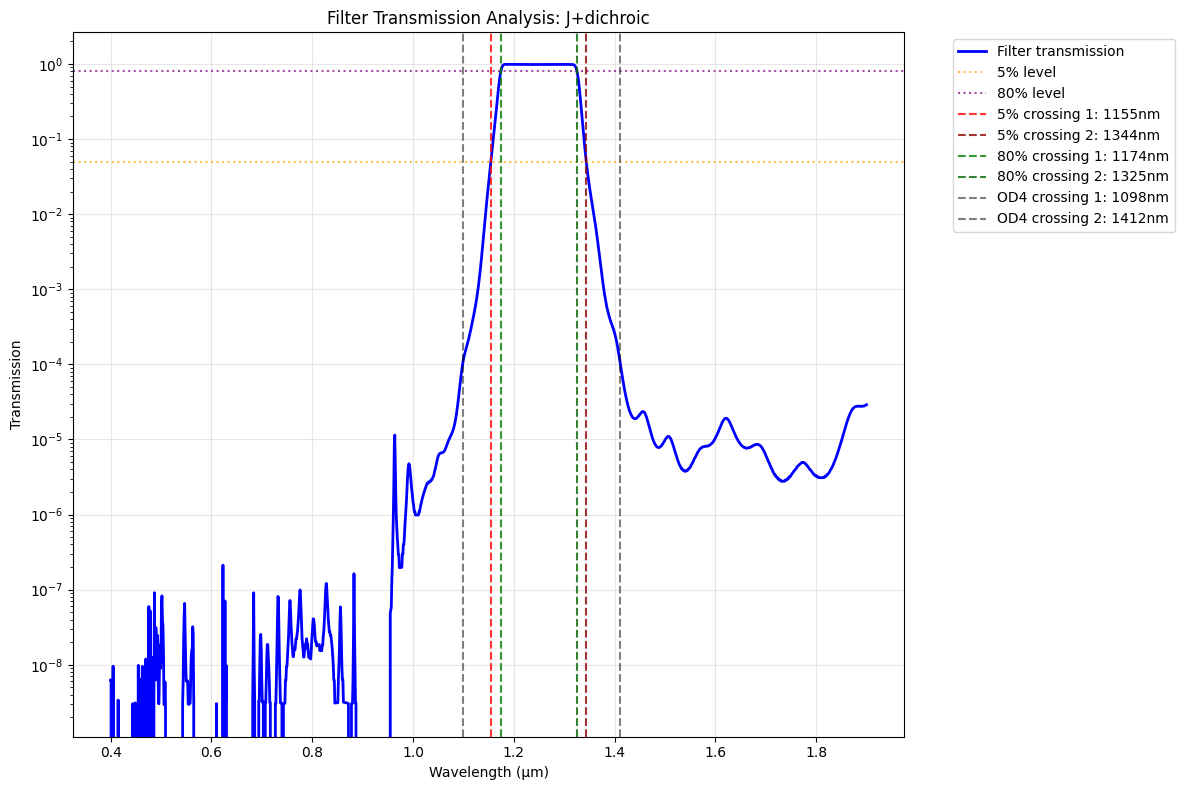


=== Filter: Y ===
Crossing 1:
  Wavelength at 5%: 942.989 nm
  Wavelength at 80%: 958.025 nm
  Transition wavelength: 950.507 nm
  Calculated slope: 1.59 %
  Crossing OD4: 894.859 nm
  Wavelength difference: -55.648 nm
Crossing 2:
  Wavelength at 5%: 1067.880 nm
  Wavelength at 80%: 1051.404 nm
  Transition wavelength: 1059.642 nm
  Calculated slope: -1.54 %
  Crossing OD4: 1124.371 nm
  Wavelength difference: 64.729 nm

Main transition regions:
5% transition: 942.989 - 1067.880 nm (width: 124.890 nm)
80% transition: 958.025 - 1051.404 nm (width: 93.379 nm)
5% center: 1005.435 nm
80% center: 1004.715 nm
Mean transmission in 5% region: 0.8125
Mean transmission in 80% region: 0.9921


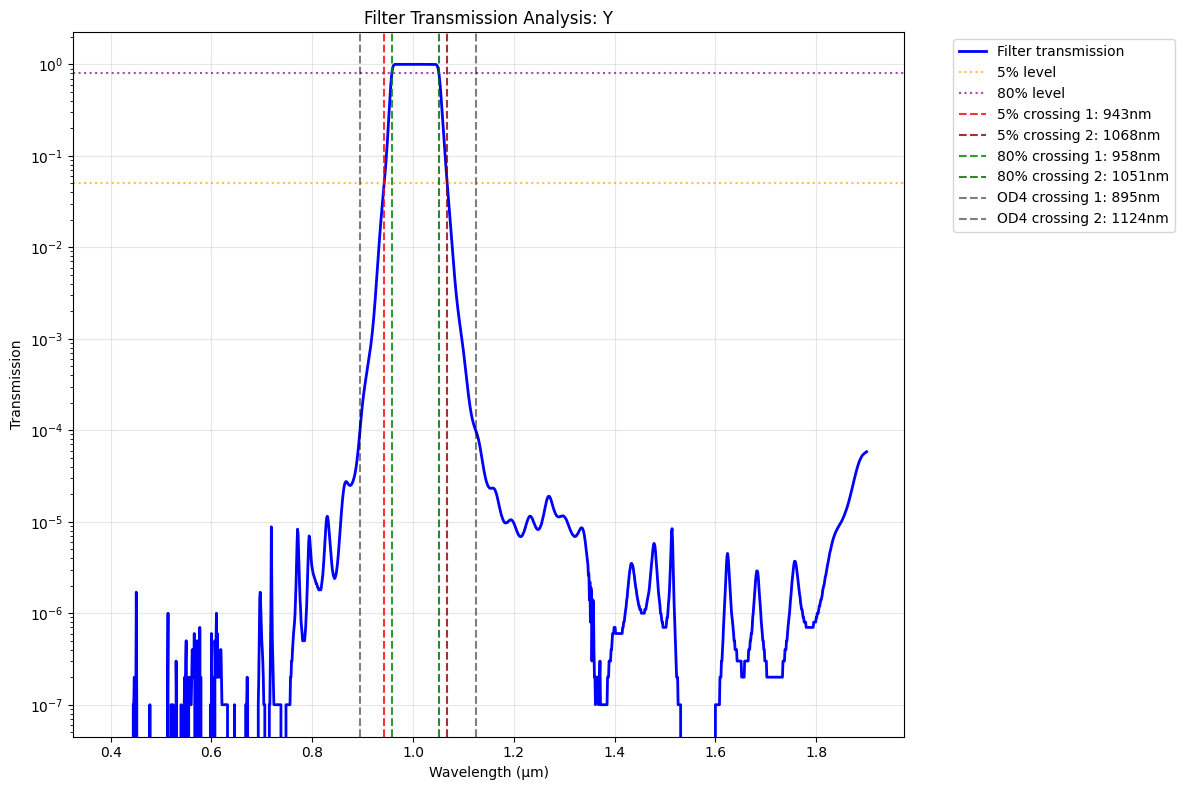


=== Filter: J ===
Crossing 1:
  Wavelength at 5%: 1154.534 nm
  Wavelength at 80%: 1174.281 nm
  Transition wavelength: 1164.407 nm
  Calculated slope: 1.71 %
  Crossing OD4: 1098.350 nm
  Wavelength difference: -66.057 nm
Crossing 2:
  Wavelength at 5%: 1344.023 nm
  Wavelength at 80%: 1325.657 nm
  Transition wavelength: 1334.840 nm
  Calculated slope: -1.37 %
  Crossing OD4: 1411.764 nm
  Wavelength difference: 76.924 nm

Main transition regions:
5% transition: 1154.534 - 1344.023 nm (width: 189.489 nm)
80% transition: 1174.281 - 1325.657 nm (width: 151.377 nm)
5% center: 1249.279 nm
80% center: 1249.969 nm
Mean transmission in 5% region: 0.8512
Mean transmission in 80% region: 0.9936


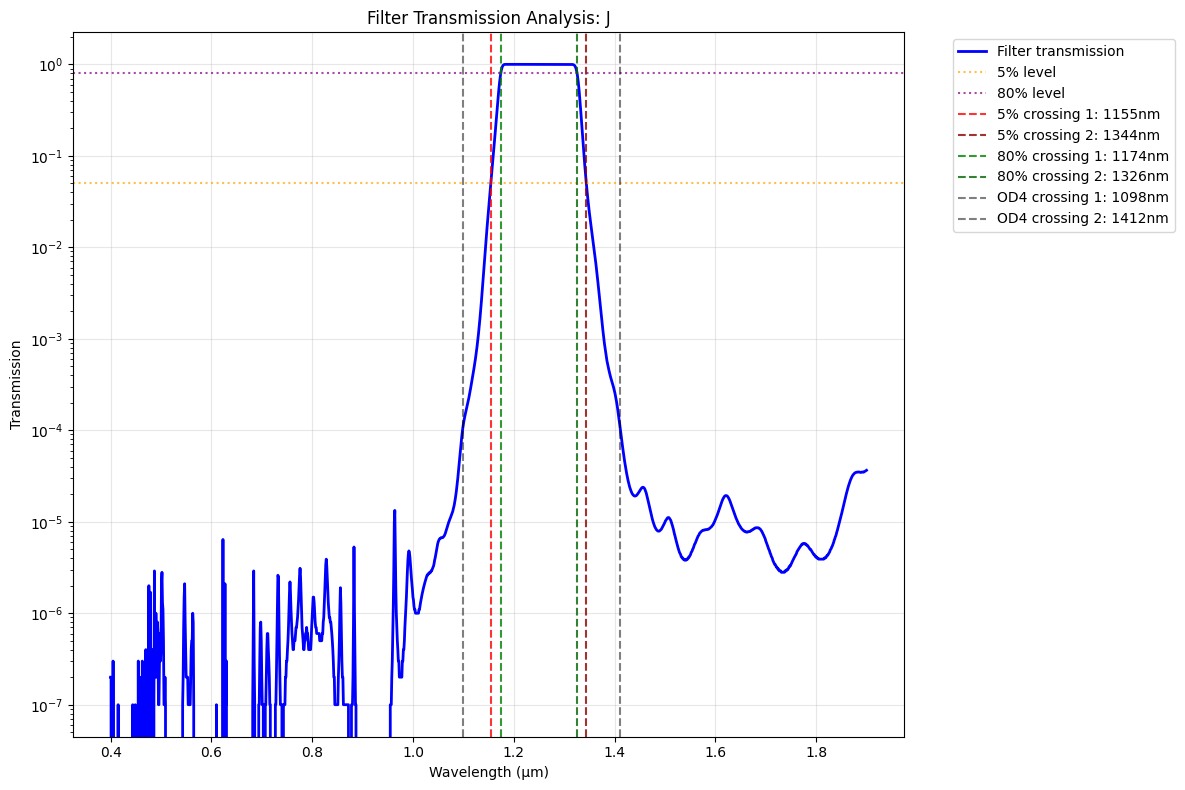


=== Filter: H+dichroic ===
Crossing 1:
  Wavelength at 5%: 1502.242 nm
  Wavelength at 80%: 1521.905 nm
  Transition wavelength: 1512.074 nm
  Calculated slope: 1.31 %
  Crossing OD4: 1447.496 nm
  Wavelength difference: -64.578 nm


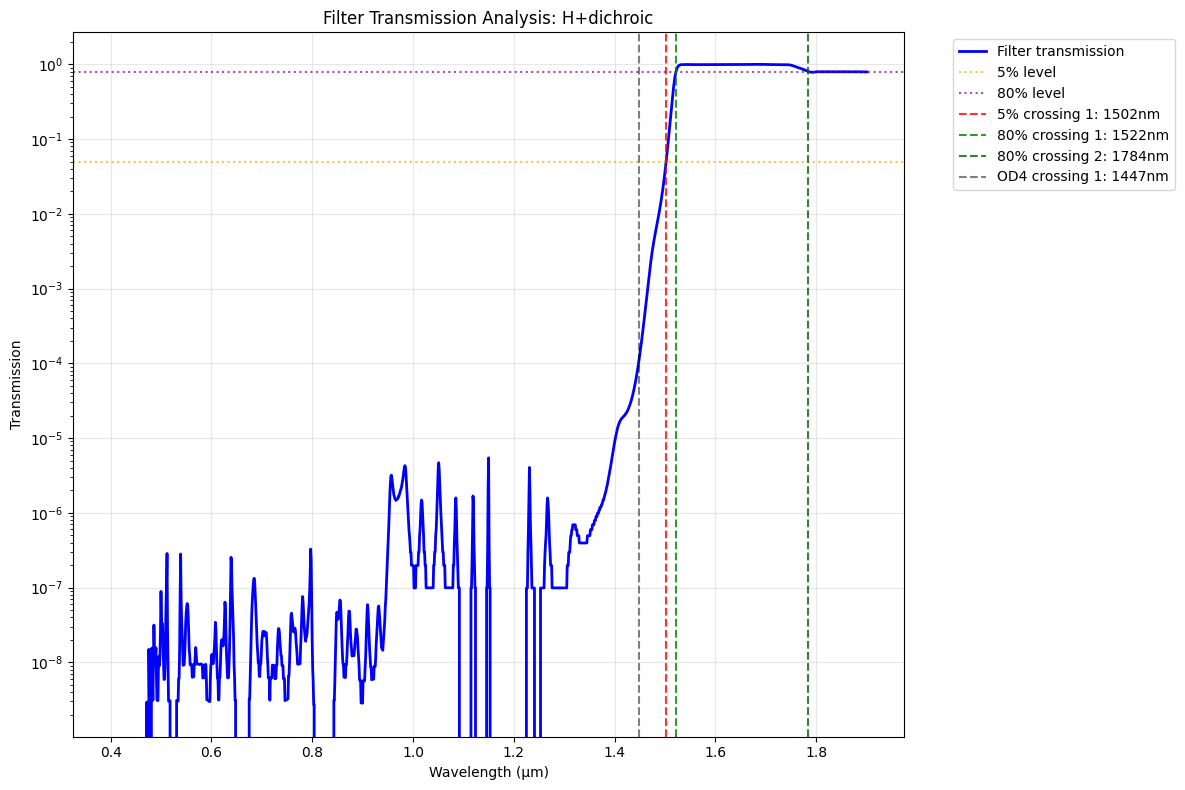


=== Filter: Y+J ===
Crossing 1:
  Wavelength at 5%: 943.641 nm
  Wavelength at 80%: 958.557 nm
  Transition wavelength: 951.099 nm
  Calculated slope: 1.58 %
  Crossing OD4: 900.588 nm
  Wavelength difference: -50.511 nm
Crossing 2:
  Wavelength at 5%: 1342.568 nm
  Wavelength at 80%: 1325.970 nm
  Transition wavelength: 1334.269 nm
  Calculated slope: -1.24 %
  Crossing OD4: 1404.913 nm
  Wavelength difference: 70.644 nm

Main transition regions:
5% transition: 943.641 - 1342.568 nm (width: 398.927 nm)
80% transition: 958.557 - 1325.970 nm (width: 367.413 nm)
5% center: 1143.104 nm
80% center: 1142.263 nm
Mean transmission in 5% region: 0.9406
Mean transmission in 80% region: 0.9953


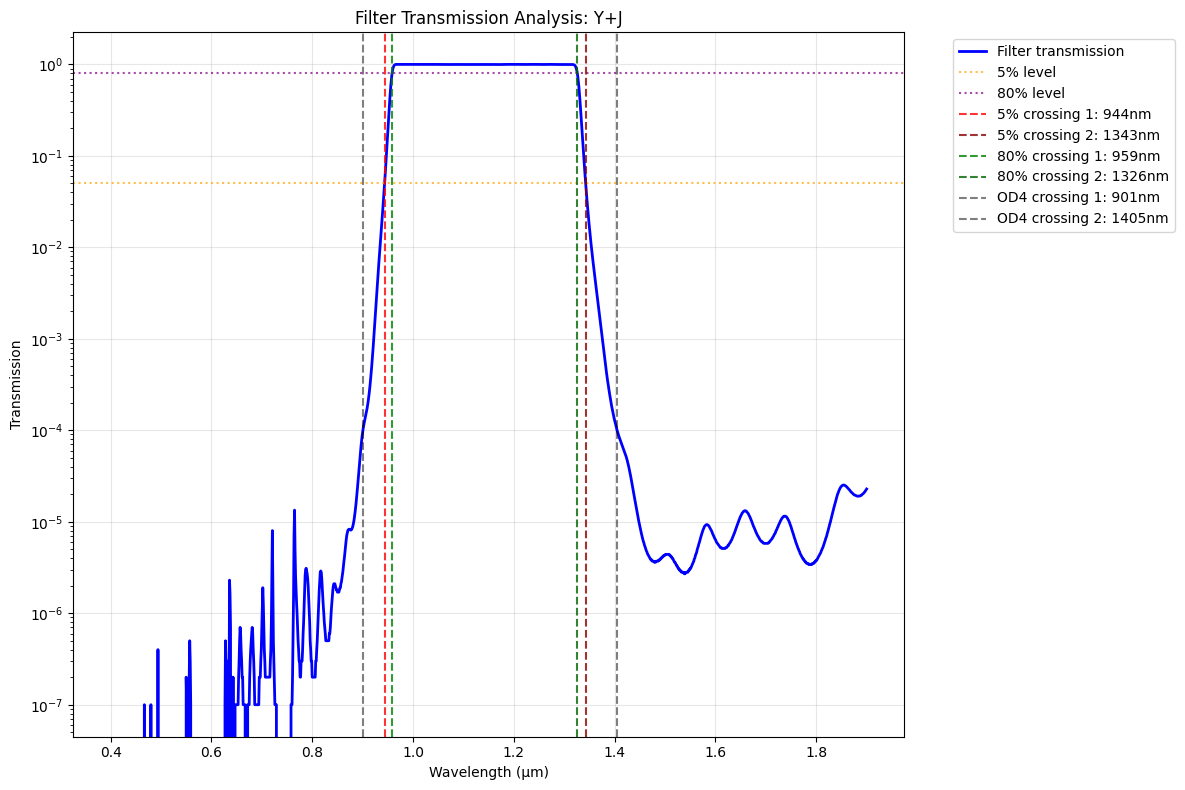


=== Filter: Y+J+dichroic ===
Crossing 1:
  Wavelength at 5%: 950.018 nm
  Wavelength at 80%: 962.755 nm
  Transition wavelength: 956.386 nm
  Calculated slope: 1.34 %
  Crossing OD4: 928.484 nm
  Wavelength difference: -27.903 nm
Crossing 2:
  Wavelength at 5%: 1342.495 nm
  Wavelength at 80%: 1325.789 nm
  Transition wavelength: 1334.142 nm
  Calculated slope: -1.24 %
  Crossing OD4: 1404.693 nm
  Wavelength difference: 70.551 nm

Main transition regions:
5% transition: 950.018 - 1342.495 nm (width: 392.477 nm)
80% transition: 962.755 - 1325.789 nm (width: 363.034 nm)
5% center: 1146.256 nm
80% center: 1144.272 nm
Mean transmission in 5% region: 0.9363
Mean transmission in 80% region: 0.9836


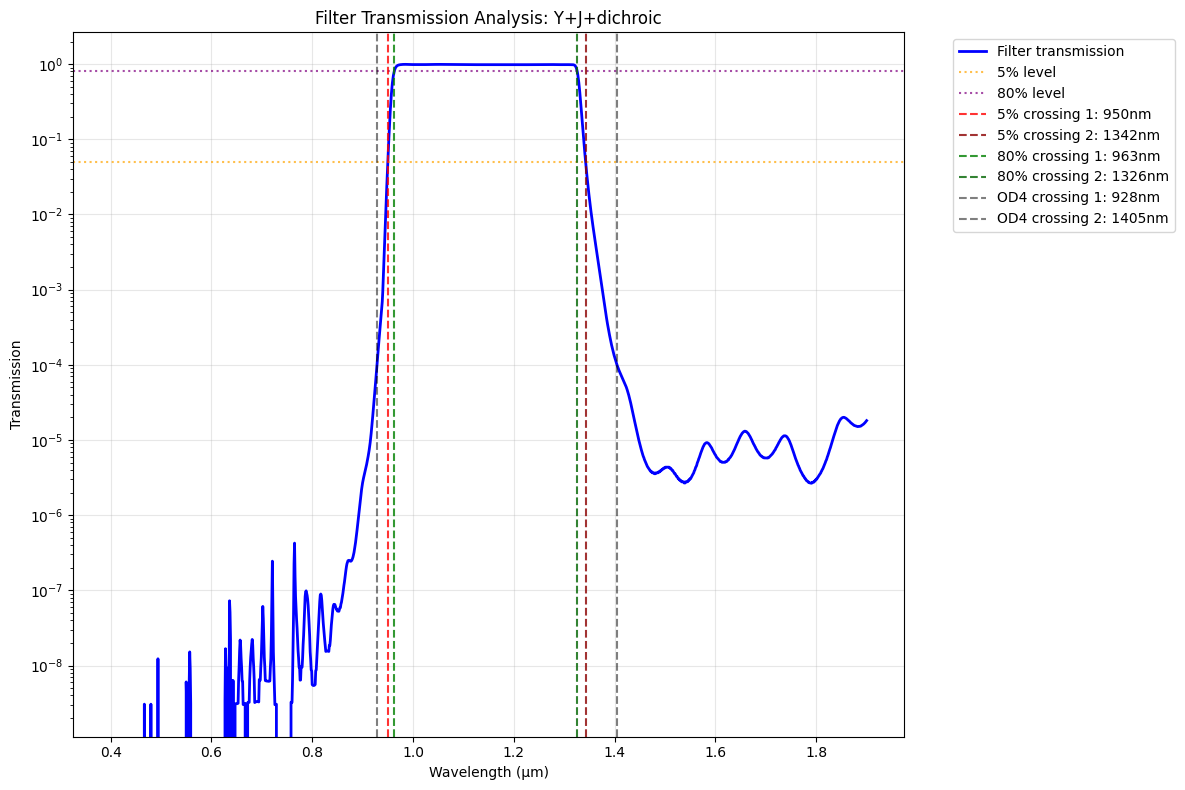


=== Filter: Y+dichroic ===
Crossing 1:
  Wavelength at 5%: 950.167 nm
  Wavelength at 80%: 962.467 nm
  Transition wavelength: 956.317 nm
  Calculated slope: 1.29 %
  Crossing OD4: 926.357 nm
  Wavelength difference: -29.960 nm
Crossing 2:
  Wavelength at 5%: 1067.839 nm
  Wavelength at 80%: 1051.345 nm
  Transition wavelength: 1059.592 nm
  Calculated slope: -1.54 %
  Crossing OD4: 1124.031 nm
  Wavelength difference: 64.439 nm

Main transition regions:
5% transition: 950.167 - 1067.839 nm (width: 117.672 nm)
80% transition: 962.467 - 1051.345 nm (width: 88.878 nm)
5% center: 1009.003 nm
80% center: 1006.906 nm
Mean transmission in 5% region: 0.8238
Mean transmission in 80% region: 0.9778


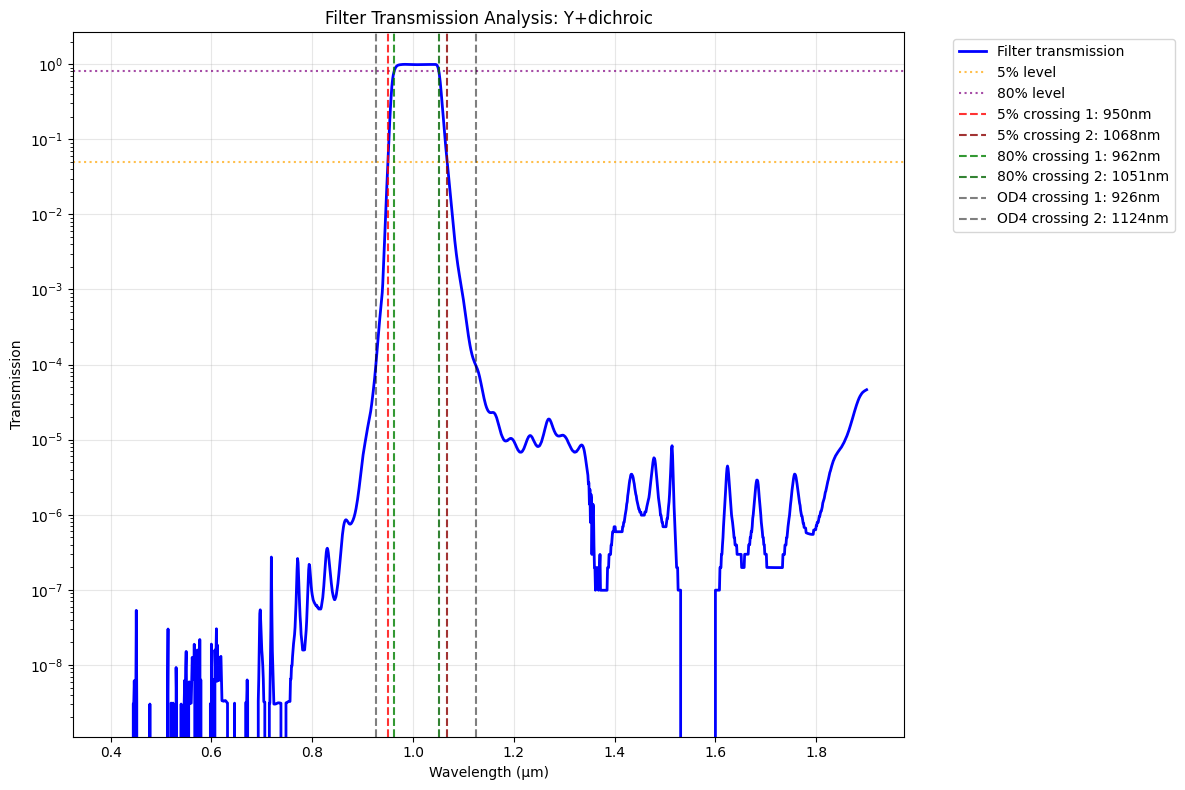


=== Filter: H ===
Crossing 1:
  Wavelength at 5%: 1502.169 nm
  Wavelength at 80%: 1521.751 nm
  Transition wavelength: 1511.960 nm
  Calculated slope: 1.30 %
  Crossing OD4: 1447.381 nm
  Wavelength difference: -64.579 nm


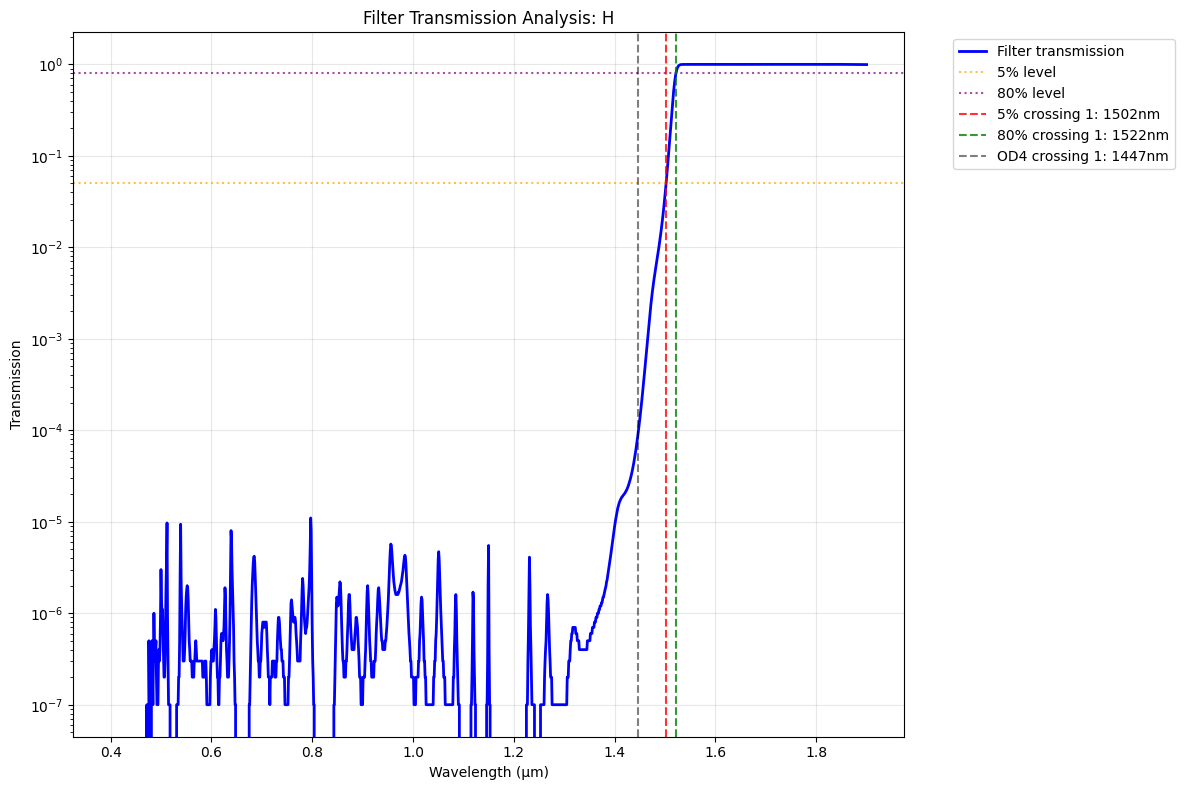

In [17]:
for filter_path in glob("../resources/filters/*_asahi.csv"):
    # if "dichroic" in filter_path:
    #     continue

    filter_name = filter_path.split("/")[-1].replace("_asahi.csv", "")
    print(f"\n=== Filter: {filter_name} ===")

    # Define parameters
    blue_transmission = 0.05  # Transmission in the blue region (5%)
    red_transmission = 0.8  # Transmission in the red region (80%)

    df_filter = pd.read_csv(filter_path, index_col=0, header=None)

    # Calculate the filter transmission
    wavelength = df_filter.index[100:-100]
    transmission = df_filter.values[100:-100].flatten()

    # Find all crossing points for each transmission level
    def find_crossings(wavelengths, transmissions, target_level):
        """Find all points where transmission crosses the target level"""
        crossings = []
        for i in range(len(transmissions) - 1):
            # Check if there's a crossing between consecutive points
            if (transmissions[i] <= target_level <= transmissions[i + 1]) or (
                transmissions[i] >= target_level >= transmissions[i + 1]
            ):
                # Linear interpolation to find exact crossing point
                if transmissions[i + 1] != transmissions[i]:  # Avoid division by zero
                    frac = (target_level - transmissions[i]) / (
                        transmissions[i + 1] - transmissions[i]
                    )
                    crossing_wavelength = wavelengths[i] + frac * (
                        wavelengths[i + 1] - wavelengths[i]
                    )
                    crossings.append(crossing_wavelength)
        return np.array(crossings)

    # Find all crossings for both transmission levels
    crossings_5pct = find_crossings(wavelength, transmission, blue_transmission)
    crossings_80pct = find_crossings(wavelength, transmission, red_transmission)
    crossingOD4 = find_crossings(wavelength, transmission, 1e-4)

    # Calculate the actual slope
    for i, crossing in enumerate(crossings_5pct):

        transition_wavelength = (crossings_80pct[i] + crossings_5pct[i]) / 2

        slope_calc = (crossings_80pct[i] - crossings_5pct[i]) / crossings_5pct[i] * 100

        print(f"Crossing {i+1}:")
        print(f"  Wavelength at 5%: {crossings_5pct[i]*1000:.3f} nm")
        print(f"  Wavelength at 80%: {crossings_80pct[i]*1000:.3f} nm")
        print(f"  Transition wavelength: {transition_wavelength*1000:.3f} nm")
        print(f"  Calculated slope: {slope_calc:.2f} %")
        print(
            f"  Crossing OD4: {crossingOD4[i]*1000:.3f} nm"
        )  # Print the crossing point for OD4
        print(
            f"  Wavelength difference: {(crossingOD4[i] - transition_wavelength)*1000:.3f} nm"
        )

    # Calculate transition characteristics if we have pairs
    if len(crossings_5pct) >= 2 and len(crossings_80pct) >= 2:
        # For multiple crossings, typically we want the main transition region
        # Usually this is the largest gap between consecutive crossings
        if len(crossings_5pct) > 2:
            # Find the pair with largest separation
            max_gap_5 = 0
            best_pair_5 = (0, 1)
            for i in range(len(crossings_5pct) - 1):
                gap = crossings_5pct[i + 1] - crossings_5pct[i]
                if gap > max_gap_5:
                    max_gap_5 = gap
                    best_pair_5 = (i, i + 1)
            w_min_5 = crossings_5pct[best_pair_5[0]]
            w_max_5 = crossings_5pct[best_pair_5[1]]
        else:
            w_min_5 = crossings_5pct[0]
            w_max_5 = crossings_5pct[1]

        if len(crossings_80pct) > 2:
            # Find the pair with largest separation
            max_gap_80 = 0
            best_pair_80 = (0, 1)
            for i in range(len(crossings_80pct) - 1):
                gap = crossings_80pct[i + 1] - crossings_80pct[i]
                if gap > max_gap_80:
                    max_gap_80 = gap
                    best_pair_80 = (i, i + 1)
            w_min_80 = crossings_80pct[best_pair_80[0]]
            w_max_80 = crossings_80pct[best_pair_80[1]]
        else:
            w_min_80 = crossings_80pct[0]
            w_max_80 = crossings_80pct[1]

        # Calculate transition characteristics
        transition_width_5 = w_max_5 - w_min_5
        transition_width_80 = w_max_80 - w_min_80
        transition_center_5 = (w_min_5 + w_max_5) / 2
        transition_center_80 = (w_min_80 + w_max_80) / 2

        print(f"\nMain transition regions:")
        print(
            f"5% transition: {w_min_5*1000:.3f} - {w_max_5*1000:.3f} nm (width: {transition_width_5*1000:.3f} nm)"
        )
        print(
            f"80% transition: {w_min_80*1000:.3f} - {w_max_80*1000:.3f} nm (width: {transition_width_80*1000:.3f} nm)"
        )
        print(f"5% center: {transition_center_5*1000:.3f} nm")
        print(f"80% center: {transition_center_80*1000:.3f} nm")

        # mean transmission in the transition region
        mean_transmission_5 = np.mean(
            transmission[(wavelength >= w_min_5) & (wavelength <= w_max_5)]
        )
        mean_transmission_80 = np.mean(
            transmission[(wavelength >= w_min_80) & (wavelength <= w_max_80)]
        )
        print(f"Mean transmission in 5% region: {mean_transmission_5:.4f}")
        print(f"Mean transmission in 80% region: {mean_transmission_80:.4f}")

    # Create the plot
    plt.figure(figsize=(12, 8))
    plt.plot(wavelength, transmission, "b-", linewidth=2, label="Filter transmission")

    # Plot horizontal lines for reference levels
    plt.axhline(
        y=blue_transmission,
        color="orange",
        linestyle=":",
        alpha=0.7,
        label=f"{blue_transmission*100:.0f}% level",
    )
    plt.axhline(
        y=red_transmission,
        color="purple",
        linestyle=":",
        alpha=0.7,
        label=f"{red_transmission*100:.0f}% level",
    )

    # Plot all crossing points
    colors_5 = ["red", "darkred", "crimson", "maroon"]
    colors_80 = ["green", "darkgreen", "forestgreen", "olive"]

    for i, crossing in enumerate(crossings_5pct):
        color = colors_5[i % len(colors_5)]
        plt.axvline(
            x=crossing,
            color=color,
            linestyle="--",
            alpha=0.8,
            label=f"5% crossing {i+1}: {crossing*1000:.0f}nm",
        )

    for i, crossing in enumerate(crossings_80pct):
        color = colors_80[i % len(colors_80)]
        plt.axvline(
            x=crossing,
            color=color,
            linestyle="--",
            alpha=0.8,
            label=f"80% crossing {i+1}: {crossing*1000:.0f}nm",
        )

    for i, crossing in enumerate(crossingOD4):
        plt.axvline(
            x=crossing,
            color="black",
            linestyle="--",
            alpha=0.5,
            label=f"OD4 crossing {i+1}: {crossing*1000:.0f}nm",
        )

    plt.title(f"Filter Transmission Analysis: {filter_name}")
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Transmission")
    plt.yscale("log")
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

## Single PWV effect evaluation


In [46]:
instrument_efficiency_path = "../resources/systems/speculoos_PIRT_1280SciCam_-60.csv"  # index in microns, efficiency of telescope+instrument as fraction
filter_path = "../resources/filters/H+dichroic_asahi.csv"  # index in microns, filter efficiency as fraction

instrument_efficiency_path = "../resources/systems/speculoos_Andor_iKon-L-936_-60.csv"  # index in microns, efficiency of telescope+instrument as fraction
filter_path = "../resources/filters/r+dichroic_transmission.csv"  # index in microns, filter efficiency as fraction


name, system_response = mphot.generate_system_response(
    instrument_efficiency_path, filter_path
)

`/opt/homebrew/Caskroom/miniconda/base/envs/mphot_pip/lib/python3.11/site-packages/mphot/datafiles/system_responses/speculoos_Andor_iKon-L-936_-60_r+dichroic_transmission_instrument_system_response.csv` has been generated and saved!


<Axes: title={'center': 'speculoos_Andor_iKon-L-936_-60_r+dichroic_transmission'}, xlabel='Wavelength (microns)', ylabel='System Response'>

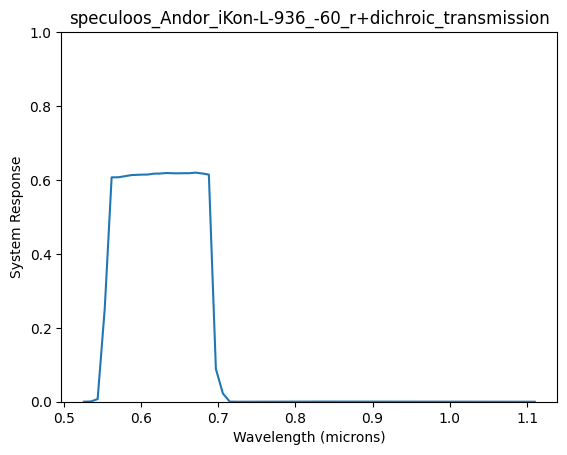

In [47]:
system_response.plot(
    xlabel="Wavelength (microns)", ylabel="System Response", title=name, ylim=(0, 1)
)

In [48]:
pwvs = np.arange(0.05, 20, 0.5)  # [mm]
teffs = np.arange(2000, 6500, 500)  # [K]

# sky properties
props_sky = {
    "pwv": 2.5,  # PWV [mm]
    "airmass": 1.1,  # airmass
    "seeing": 1.35,  # seeing (==FWHM) ["]
}

# instrument properties
props_instrument = {
    "name": name,  # name to get SR/precision grid from file
    "plate_scale": 0.31,  # pixel plate scale ["]
    "N_dc": 110,  # dark current [e/pix/s]
    "N_rn": 90,  # read noise [e_rms/pix]
    "well_depth": 56000,  # well depth [e/pix]
    "well_fill": 0.7,  # fractional value to fill central target pixel, assuming gaussian (width function of seeing^)
    "read_time": 0.1,  # read time between images [s]
    "r0": 0.5,  # radius of telescope's primary mirror [m]
    "r1": 0.14,  # radius of telescope's secondary mirror [m]
    # "min_exp" : 0,          # optional, minimum exposure time [s]
    # "max_exp" : 120,        # optional, maximum exposure time [s]
    # "ap_rad" : 3            # optional, aperture radius [FWHM, seeing] for photometry -- 3 default == 7 sigma of Gaussian
}

# target properties
# Teff = 2566  # [K]
distance = 12.5  # [pc]

In [49]:
fluxes = {}
for Teff in teffs:
    fluxes[Teff] = {}
    for pwv in pwvs:
        props_sky["pwv"] = pwv
        props_instrument["name"] = name
        image_precision, binned_precision, components = mphot.get_precision(
            props_instrument,
            props_sky,
            Teff,
            distance,
            extended=False,
            SPCcorrection=False,
        )
        fluxes[Teff][pwv] = components["N_star [e/s]"]

Progress: [####################] 100.0%


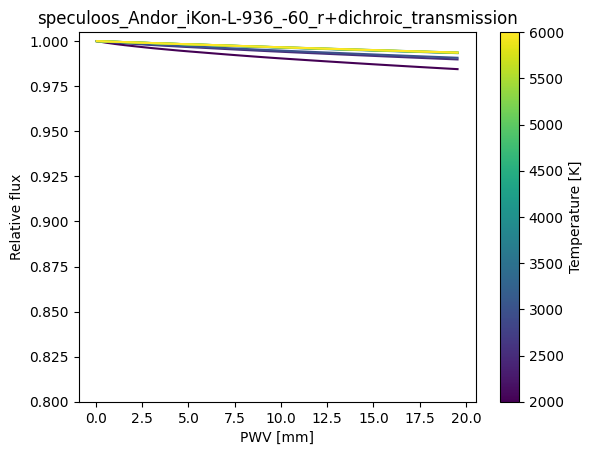

In [50]:
# plot relative flux vs PWV for each Teff, where relative flux is flux / flux_0, where flux_0 is the flux at 0.05 mm per Teff
fig, ax = plt.subplots()
norm = plt.Normalize(vmin=teffs.min(), vmax=teffs.max())
cmap = plt.cm.viridis
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

for Teff in teffs:
    ax.plot(
        pwvs,
        [fluxes[Teff][pwv] / fluxes[Teff][0.05] for pwv in pwvs],
        label=f"{Teff} K",
        color=cmap(norm(Teff)),
    )

ax.set_ylim(0.8, 1.005)
ax.set_xlabel("PWV [mm]")
ax.set_ylabel("Relative flux")
ax.set_title(f"{name}")
fig.colorbar(sm, ax=ax, label="Temperature [K]")

In [51]:
Teff_high_delta_flux = fluxes[teffs[-1]][pwvs[-1]] / fluxes[teffs[-1]][0.05]
Teff_low_delta_flux = fluxes[teffs[0]][pwvs[-1]] / fluxes[teffs[0]][0.05]
print(
    f"Teff high delta flux: {Teff_high_delta_flux}"
    f"\nTeff low delta flux: {Teff_low_delta_flux}"
)
# print(1 - Teff_low_delta_flux)
# The diff metric quantifies the difference in relative flux change between the highest and lowest Teff (stellar effective temperature) as PWV (precipitable water vapor) increases from its minimum to maximum value.
# Specifically, it measures how much more the relative flux drops for the hottest star compared to the coolest star, scaled by the fractional flux loss of the coolest star.
# This helps assess how sensitive stars of different temperatures are to atmospheric water vapor absorption in the observed band.

diff = (Teff_high_delta_flux - Teff_low_delta_flux) * (1 - Teff_low_delta_flux)
print(diff)

Teff high delta flux: 0.9936482743961546
Teff low delta flux: 0.9844665993467834
0.00014262263720952496
